In [1]:
# preprocessing.py
def create_iterator(data_generator, directory, batch_size):
  
    return data_generator.flow_from_directory(
        directory,
        class_mode = "categorical",
        color_mode = "grayscale",
        batch_size = batch_size
    )

In [2]:
# visualize.py
from tensorflow.keras import Model
from tensorflow import argmax
from tensorflow import expand_dims
from matplotlib import pyplot as plt

#Visualizes convolutional layer activations
def visualize_activations(model, validation_iterator):
    #A keras model that will output our previous model's activations for each convolutional layer:
    activation_extractor = Model(
        inputs = model.inputs, 
        outputs = [layer.output for layer in model.layers if "conv2d" in layer.name]
    )

    #Take matplotlib frame and remove axes.
    def clean_plot(plot):
        plot.axes.get_xaxis().set_visible(False)
        plot.axes.get_yaxis().set_visible(False)

    #Dict mapping from class numbers to string labels:
    class_names = {
        0: "Covid",
        1: "Normal",
        2: "Pneumonia"
    }

    #Loads a sample batch of data
    sample_batch_input, sample_labels = validation_iterator.next()
    
    #Grabs the first five images
    sample_batch_input = sample_batch_input[:5]
    sample_labels = sample_labels[:5]

    #Makes predictions using model.predict(x)
    sample_predictions = model.predict(sample_batch_input)

    #Iterate of images, predictions, and true labels
    for i, (image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

        image_name = "X_ray{}".format(i)

        #Gets predicted class with highest probability
        predicted_class = argmax(prediction).numpy()

        #Gets correct label
        actual_class = argmax(label).numpy()

        print(image_name)
        print("\tModel prediction: {}".format(prediction))
        print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
        print("\tCorrect:", predicted_class == actual_class)

        #Saves image file using matplotlib
        sample_image = image
        clean_plot(plt.imshow(
            sample_image[:, :, 0],
            cmap = "gray"
        ))
        plt.title(image_name + " Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
        plt.tight_layout()
        plt.show()
        model_layer_output = activation_extractor(expand_dims(sample_image, 0))
        
        plt.clf()

        #Iterates over each layer output
        for l_num, output_data in enumerate(model_layer_output):
            #Creates a subplot for each filter
            fig, axs = plt.subplots(1, output_data.shape[-1])
            
            #For each filter
            for i in range(output_data.shape[-1]):
                #Plots the filter's activations
                clean_plot(axs[i].imshow(output_data[0][:, :, i], cmap = "gray"))
        
            plt.suptitle(image_name + " Conv {}".format(l_num), y = 0.6)
            plt.tight_layout()
            plt.show()
            plt.clf()
    
def visualize_accuracy(history):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # plotting auc and validation auc over epochs
    keys = list(history.history.keys())
    #print(keys)
    #print(keys[2])
    #print(keys[-1])
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history[keys[2]])
    ax2.plot(history.history[keys[-1]])
    ax2.set_title('model auc')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('auc')
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


In [3]:
# report.py
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def report(model, validation_iterator):
    test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
    predictions = model.predict(validation_iterator, steps = test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis = 1)
    true_classes = validation_iterator.classes
    class_labels = list(validation_iterator.class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names = class_labels)
    
    print(report)

    cm = confusion_matrix(true_classes, predicted_classes)
    print(cm)

In [6]:
# model.py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

#from preprocessing import create_iterator
#from visualize import visualize_activations
import pprint

def design_model(training_iterator, learning_rate):
    model = Sequential()
    # set the input layer:
    model.add(Input(
        shape = training_iterator.image_shape
    ))

    # Configuring Convolutional Layer:
    model.add(Conv2D(
        5, 
        5, 
        strides = 5,
        padding = "same",
        activation = "relu"
    )) 
    model.add(Dropout(0.1))

    # Configuring Max pooling Layer:
    max_pool_2d = MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2), 
        padding = "valid"
    )
    model.add(Dropout(0.2))
    
    model.add(Conv2D(
        3, 
        3, 
        strides = 2,
        padding = "same",
        activation = "relu"
    ))

    max_pool_2d = MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2), 
        padding = "valid"
    )
    
    # Flatten Layer
    model.add(Flatten())
    """
    # set the hidden layer:
    model.add(Dense(
        2,                 #  hidden units
        activation = "relu" 
    ))
    model.add(Dropout(0.3))
    """
    # set the output layer:
    model.add(Dense(
        3, 
        activation = "softmax"
    ))

    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = CategoricalCrossentropy(),
        metrics = [
            CategoricalAccuracy(), 
            AUC()                  # we want our AUC to be as close to 1.0 as possible
        ]
    )

    model.summary()
  
    return model

def fit_model(batch_size, learning_rate, num_epochs):
  
    print("\nLoading training data...")
    training_data_generator = ImageDataGenerator(
        rescale = 1 / 255,
        zoom_range = 0.1,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05
    )
    training_iterator = create_iterator(training_data_generator, "/Users/chirag/Programs/Minor_Project/Classification/Covid19-dataset/train", batch_size)
    #print(training_iterator.image_shape)

    validation_data_generator = ImageDataGenerator(rescale = 1 / 255)
    print("\nLoading validation data...")
    validation_iterator = create_iterator(validation_data_generator, "/Users/chirag/Programs/Minor_Project/Classification/Covid19-dataset/test", batch_size)

    print("\nDesign model...")
    model = design_model(training_iterator, learning_rate)

    stop = EarlyStopping(
        monitor = "val_loss", # we are monitoring the validation loss to decide when to stop the training
        mode = "min",         # we seek minimal loss
        verbose = 1, 
        patience = 10         # if the learning reaches a plateau, 
                              # it will continue for 40 more epochs in case the plateau leads to improved performance
        )

    print("\nTraining model...")
    history = model.fit(
        training_iterator,
        steps_per_epoch = training_iterator.samples / batch_size,
        epochs = num_epochs,
        verbose = 1, 
        callbacks = [stop],
        validation_data = validation_iterator,
        validation_steps = validation_iterator.samples / batch_size
    )
    
    return history, validation_iterator


Loading training data...
Found 251 images belonging to 3 classes.

Loading validation data...
Found 66 images belonging to 3 classes.

Design model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 52, 52, 5)         130       
_________________________________________________________________
dropout (Dropout)            (None, 52, 52, 5)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 52, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 3)         138       
_________________________________________________________________
flatten (Flatten)            (None, 2028)              0         
_________________________________________________________________
dense (Dense)                (None, 

2022-05-18 09:57:25.222501: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 09:57:25.225474: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train for 7.84375 steps, validate for 2.0625 steps
Epoch 1/100
8/7 [==============================] - 3s 362ms/step - loss: 1.1060 - categorical_accuracy: 0.3705 - auc: 0.5555 - val_loss: 1.6208 - val_categorical_accuracy: 0.3939 - val_auc: 0.6965
Epoch 2/100
8/7 [==============================] - 2s 228ms/step - loss: 1.0165 - categorical_accuracy: 0.4701 - auc: 0.6951 - val_loss: 1.5323 - val_categorical_accuracy: 0.5000 - val_auc: 0.7552
Epoch 3/100
8/7 [==============================] - 2s 230ms/step - loss: 0.9523 - categorical_accuracy: 0.5578 - auc: 0.7672 - val_loss: 1.4561 - val_categorical_accuracy: 0.5455 - val_auc: 0.8066
Epoch 4/100
8/7 [==============================] - 2s 236ms/step - loss: 0.8480 - categorical_accuracy: 0.6295 - auc: 0.8337 - val_loss: 1.2519 - val_categorical_accuracy: 0.6667 - val_auc: 0.8921
Epoch 5/100
8/7 [==============================] - 2s 228ms/step - loss: 0.6685 - categorical_accuracy: 0.7689 - auc: 0.9219 - val_loss: 1.0323 - val_categorical

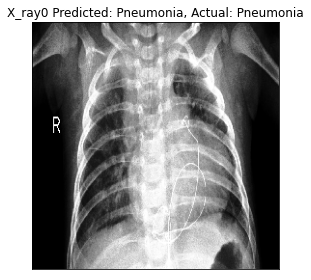

<Figure size 432x288 with 0 Axes>

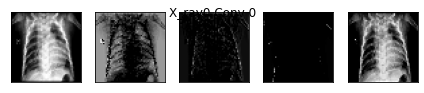

<Figure size 432x288 with 0 Axes>

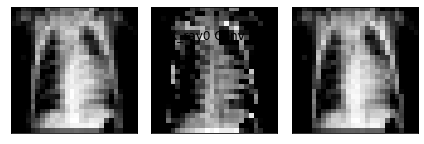

X_ray1
	Model prediction: [9.999815e-01 8.985497e-06 9.538558e-06]
	True label: Covid (0)
	Correct: True


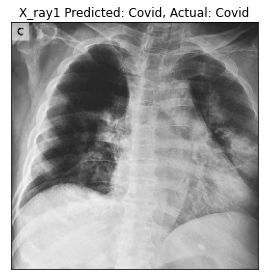

<Figure size 432x288 with 0 Axes>

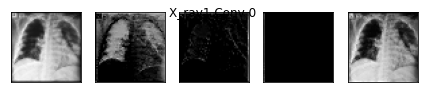

<Figure size 432x288 with 0 Axes>

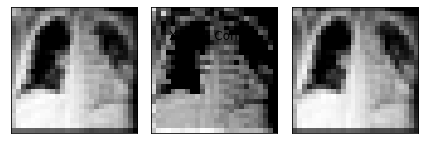

X_ray2
	Model prediction: [2.2964305e-06 1.0850622e-02 9.8914707e-01]
	True label: Pneumonia (2)
	Correct: True


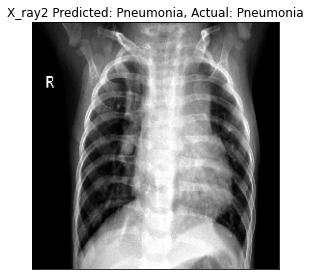

<Figure size 432x288 with 0 Axes>

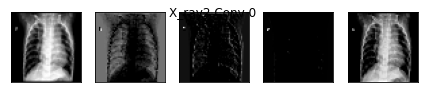

<Figure size 432x288 with 0 Axes>

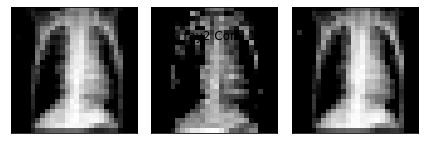

X_ray3
	Model prediction: [0.3686584  0.16490798 0.4664336 ]
	True label: Covid (0)
	Correct: False


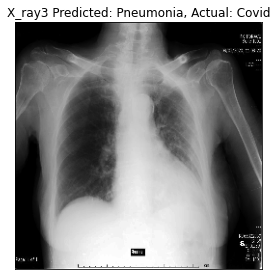

<Figure size 432x288 with 0 Axes>

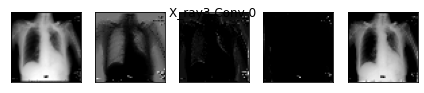

<Figure size 432x288 with 0 Axes>

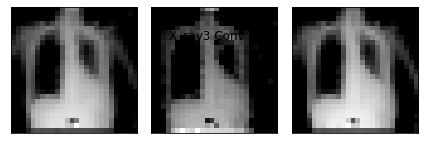

X_ray4
	Model prediction: [0.01404544 0.13951427 0.84644026]
	True label: Pneumonia (2)
	Correct: True


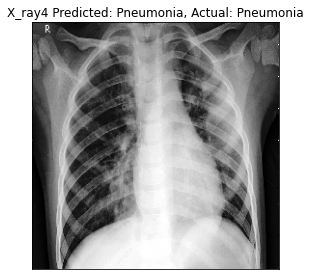

<Figure size 432x288 with 0 Axes>

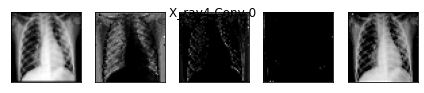

<Figure size 432x288 with 0 Axes>

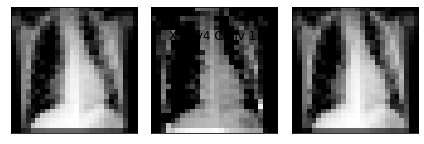

<Figure size 432x288 with 0 Axes>

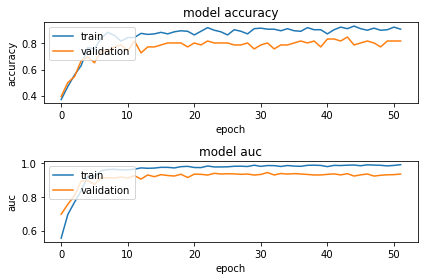

              precision    recall  f1-score   support

       Covid       0.42      0.38      0.40        26
      Normal       0.45      0.50      0.48        20
   Pneumonia       0.20      0.20      0.20        20

    accuracy                           0.36        66
   macro avg       0.36      0.36      0.36        66
weighted avg       0.36      0.36      0.36        66

[[10  4 12]
 [ 6 10  4]
 [ 8  8  4]]


In [7]:
# script.py
#from model import fit_model
#import pprint

BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100

history, validation_iterator = fit_model(BATCH_SIZE, LEARNING_RATE, EPOCHS)
model = history.model

visualize_activations(model, validation_iterator)

visualize_accuracy(history)

#pprint.pprint(history.__dict__)
#pprint.pprint(history.model.__dict__)
#print("validation_iterator")
#pprint.pprint(validation_iterator.__dict__)

report(model, validation_iterator)